# Poker Mind - Modelo ANN

#### **Introducción**
Este último módulo de **Poker Mind** tiene como objetivo utilizar una red neuronal artificial (ANN) para predecir el resultado de una partida de póker basándose en los datos de entrada proporcionados, como las cartas del jugador, las cartas comunitarias, y el número de rivales. Este modelo es un ejemplo de cómo las técnicas avanzadas de aprendizaje automático pueden aplicarse a juegos complejos para analizar y mejorar la toma de decisiones.

#### **Redes Neuronales Artificiales (ANN)**
Una red neuronal artificial (ANN) es un modelo matemático inspirado en la estructura y funcionamiento del cerebro humano. Una ANN consta de nodos interconectados, organizados en capas:

1. **Capa de entrada:** Recibe las características iniciales del problema (cartas del jugador, número de jugadores...).
2. **Capas ocultas:** Procesan y transforman los datos mediante funciones no lineales.
3. **Capa de salida:** Produce la predicción final (victoria/empate/derrota).

La ANN aprende ajustando sus pesos mediante un proceso de optimización llamado retropropagación (backpropagation), basado en el cálculo del error entre la predicción y el valor real.

#### **Modelo Matemático de una Neurona**
La salida de una neurona se calcula como:

$$
z = \sum_{i=1}^{n} w_i x_i + b
$$

Donde:
- \(x_i\): Valores de entrada.
- \(w_i\): Pesos asignados a cada entrada.
- \(b\): Término de sesgo (bias).
- \(z\): Salida ponderada (preactivación).

Posteriormente, se aplica una función de activación f(z) para introducir no linealidad:

$$
a = f(z)
$$

Algunas funciones de activación comunes incluyen:
- ReLU (Rectified Linear Unit): $$ f(z) = \max(0, z) $$
- Sigmoide: $$ f(z) = \frac{1}{1 + e^{-z}} $$

#### **Arquitectura del modelo**

La arquitectura de Poker Mind se basa en una red neuronal artificial (ANN) diseñada para predecir el resultado de una mano de póker, considerando diversas características de las cartas y el estado de la partida. Esta red tiene múltiples capas ocultas y emplea funciones de activación no lineales, como ReLU, para introducir complejidad y capacidad de generalización.

![Red Neuronal Artificial (ANN)](https://procesia.com/wp-content/uploads/2024/10/Leonardo_Lightning_XL_neural_networks_2.jpg)


#### Expresión matemática del algoritmo

Para un ejemplo de entrada $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

Luego, el coste se calcula sumando todos los ejemplos de entrenamiento:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{4}$$

### Importación de Librerías

In [1]:
import os
import pandas as pd
import numpy as np
import ast
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, LeakyReLU # type: ignore
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint # type: ignore
from tensorflow.keras.regularizers import l2 # type: ignore
import joblib
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

### Conversión de cartas a números y dataset aplanado

En esta celda, hemos convertido los valores de las cartas a numéricos y hemos aplanado el dataset de tal manera que nos queden todas las columnas separadas con números en cada columna mapeando las cartas. El proceso incluye:

1. **Conversión de cartas a números**: 
   - Se ha creado una función `carta_a_numero` que convierte las cartas de póker (por ejemplo, 'A♠' o 'K♥') a un valor numérico. Los valores de las cartas (2-14) y los palos (♠, ♣, ♦, ♥ ) se asignan con números específicos (1-4).
   
2. **Conversión de las manos**:
   - Las manos preflop ("Carta Alta Offsuit", "Carta Alta Suited" y "Pareja") se convierten a valores numéricos mediante la función `clasifica_mano_preflop` y las manos clásicas de Póker (Carta Alta, Pareja, Doble Pareja...) con la función `clasifica_mano`.

3. **Procesamiento de columnas**:
   - Se han aplanado las columnas que contienen las cartas del jugador y las cartas comunitarias (flop, turn, river). Cada carta ha sido separada y convertida a un valor numérico correspondiente.
   - Las manos preflop, flop, turn y river también se han convertido en valores numéricos utilizando las funciones correspondientes.

4. **Resultado**: 
   - Se ha convertido el resultado de la mano (Victoria, Empate, Derrota) en números: `Victoria = 2`, `Empate = 1`, `Derrota = 0`.

### Ejemplo de línea con el dataset aplanado

A continuación se muestra un ejemplo de una línea de datos después de aplicar el aplanado y conversión a números:

| carta_1 | carta_2 | num_rivales | mano_preflop | flop_1 | flop_2 | flop_3 | mano_flop | turn | mano_turn | river | mano_river |
|---------|---------|-------------|--------------|--------|--------|--------|-----------|------|-----------|-------|------------|
| 94      | 122     | 5           | 0            | 33     | 124    | 144    | 1         | 112  | 1         | 111   | 2          | 

Finalmente, el DataFrame resultante contiene solo las columnas numéricas relevantes, que serán utilizadas para entrenar el modelo.


In [2]:
# Convertimos las cartas en números
def carta_a_numero(carta):
    valores = {'2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10': 10, 'J': 11, 'Q': 12, 'K': 13, 'A': 14}
    palos = {'♠': 1, '♣': 2, '♦': 3, '♥': 4}
    
    valor = carta[:-1]
    palo = carta[-1]
    
    return valores[valor] * 10 + palos[palo]

# CONVERTIMOS LAS MANOS EN NÚMEROS

# Manos preflop
def clasifica_mano_preflop(mano):
    manos = {"Carta Alta Offsuit": 0, "Carta Alta Suited": 1, "Pareja Offsuit": 2}
    return manos.get(mano, -1)

# Manos flop, turn y river
def clasifica_mano(mano):
    manos = {"Carta Alta": 0, "Pareja": 1, "Doble Pareja": 2, "Trío": 3, "Escalera": 4, "Color": 5, "Full": 6, "Póker": 7, "Escalera de Color": 8, "Escalera Real": 9}
    return manos.get(mano, -1)

# Convertimos los resultados a números
def resultado_a_numero(resultado):
    if resultado == 'Victoria':
        return 2
    elif resultado == 'Empate':
        return 1
    else:
        return 0  # Derrota

# Leemos el dataset original para procesarlo
df = pd.read_csv('data/simulacion_montecarlo.csv')

# Aplanamos las columnas de cartas del jugador y convertirlas a números
df['carta_1'] = df['cartas_jugador'].apply(lambda x: carta_a_numero(ast.literal_eval(x)[0]))
df['carta_2'] = df['cartas_jugador'].apply(lambda x: carta_a_numero(ast.literal_eval(x)[1]))

# Convertimos las columnas de cartas del flop, turn y river directamente
df['flop_1'] = df['flop'].apply(lambda x: carta_a_numero(ast.literal_eval(x)[0]))
df['flop_2'] = df['flop'].apply(lambda x: carta_a_numero(ast.literal_eval(x)[1]))
df['flop_3'] = df['flop'].apply(lambda x: carta_a_numero(ast.literal_eval(x)[2]))

df['turn'] = df['turn'].apply(lambda x: carta_a_numero(ast.literal_eval(x)[0]))

df['river'] = df['river'].apply(lambda x: carta_a_numero(ast.literal_eval(x)[0]))

# Convertimos la columna de cartas_river en 5 columnas diferentes para obtener la mano final del jugador en 5 colmnas distintas
df['carta_final_1'] = df['cartas_river'].apply(lambda x: carta_a_numero(ast.literal_eval(x)[0]))
df['carta_final_2'] = df['cartas_river'].apply(lambda x: carta_a_numero(ast.literal_eval(x)[1]))
df['carta_final_3'] = df['cartas_river'].apply(lambda x: carta_a_numero(ast.literal_eval(x)[2]))
df['carta_final_4'] = df['cartas_river'].apply(lambda x: carta_a_numero(ast.literal_eval(x)[3]))
df['carta_final_5'] = df['cartas_river'].apply(lambda x: carta_a_numero(ast.literal_eval(x)[4]))

# Convertimos las clasificaciones de mano (preflop, flop, turn, river) a números
df['mano_preflop'] = df['mano_preflop'].apply(clasifica_mano_preflop)
df['mano_flop'] = df['mano_flop'].apply(clasifica_mano)
df['mano_turn'] = df['mano_turn'].apply(clasifica_mano)
df['mano_river'] = df['mano_river'].apply(clasifica_mano)

# Convertimos el resultado a números
df['resultado'] = df['resultado'].apply(resultado_a_numero)

# Seleccionamos las columnas que tendrá el dataset procesado
df_procesado= df[['carta_1', 'carta_2', 'num_rivales', 'mano_preflop', 'flop_1', 'flop_2', 'flop_3', 'mano_flop', 
               'turn', 'mano_turn', 'river', 'mano_river', 'carta_final_1', 'carta_final_2', 'carta_final_3', 'carta_final_4', 'carta_final_5', 'resultado']]

# Si lo deseas puedes guardar el dataset procesado en un archivo CSV para ver su arquitectura y entender mejor el modelo
# df_procesado.to_csv('data/simulacion_montecarlo_procesado.csv', index=False)

### Escalado de Datos (Normalización)

El escalado de datos es un paso clave en el preprocesamiento de datos antes de entrenar un modelo de Machine Learning. Este proceso asegura que todas las características numéricas del dataset tengan el mismo rango, lo que mejora la eficiencia del modelo y la convergencia durante el entrenamiento.

#### Explicación del Código:

1. **MinMaxScaler**:
   - Utilizamos `MinMaxScaler`, un escalador que transforma los datos numéricos de las características a un rango específico, típicamente entre 0 y 1.
   - La fórmula para la transformación de cada valor es:
     $$
     X_{\text{escalado}} = \frac{X - X_{\text{min}}}{X_{\text{max}} - X_{\text{min}}}
     $$
     Donde encontramos los valores mínimo y máximo de la característica.

2. **Separación de características y etiqueta**:
   - Separamos las características (X) y la variable objetivo (y) antes de realizar el escalado. La columna `resultado` es la variable objetivo, mientras que todas las demás columnas son las características que se usarán para entrenar el modelo.

3. **Aplicación del escalado**:
   - Aplicamos el escalador `MinMaxScaler` a las características `X` y generamos un nuevo conjunto de características escaladas (`X_scaled`).

In [3]:
scaler = MinMaxScaler()
X = df_procesado.drop(columns=['resultado'])
X_scaled = scaler.fit_transform(X)

y = df_procesado['resultado']

joblib.dump(scaler, 'models/scaler.pkl') # Guardamos el escalador para poder usarlo en el servidor

### División del Conjunto de Datos en Entrenamiento y Test

Dividimos el conjunto de datos en dos partes: entrenamiento (80%) y test (20%), utilizando la función `train_test_split` de `sklearn`. El conjunto de entrenamiento se usa para entrenar el modelo, mientras que el conjunto de test se emplea para evaluar su rendimiento en datos no vistos.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


### Arquitectura del Modelo de Red Neuronal

El modelo está basado en una red neuronal profunda, utilizando una serie de capas densas (fully connected) con regularización L2, normalización por lotes (BatchNormalization), activación LeakyReLU y Dropout para evitar el sobreajuste.

#### Capas del modelo:

1. **Capa de entrada**: 
   - Forma: (Número de características de entrada, `X_train.shape[1]`).
   
2. **Capas ocultas**:
   - **Capa densa 1**: 1024 neuronas, regularización L2, activación LeakyReLU y Dropout del 30%.
   - **Capa densa 2**: 512 neuronas, regularización L2, activación LeakyReLU y Dropout del 30%.
   - **Capa densa 3**: 256 neuronas, regularización L2, activación LeakyReLU y Dropout del 20%.
   - **Capa densa 4**: 128 neuronas, regularización L2, activación LeakyReLU y Dropout del 10%.

3. **Capa de salida**:
   - **Predicción**: 3 clases, activación `softmax` para clasificación multiclase.

#### Compilación:
- **Optimizador**: Adam con tasa de aprendizaje de 0.0005.
- **Función de pérdida**: `sparse_categorical_crossentropy` (para clasificación multiclase).
- **Métricas**: Exactitud (`accuracy`).

In [5]:
model = Sequential([
    Input(shape=(X_train.shape[1],)),

    Dense(1024, activation=None, kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    LeakyReLU(negative_slope=0.1),
    Dropout(0.3),

    Dense(512, activation=None, kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    LeakyReLU(negative_slope=0.1),
    Dropout(0.3),

    Dense(256, activation=None, kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    LeakyReLU(negative_slope=0.1),
    Dropout(0.2),

    Dense(128, activation=None, kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    LeakyReLU(negative_slope=0.1),
    Dropout(0.1),

    Dense(3, activation='softmax')
])

# Compilación del modelo
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1024)           │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 715,523 (2.73 MB)

 Trainable params: 711,683 (2.71 MB)

 Non-trainable params: 3,840 (15.00 KB)

### Entrenamiento del Modelo

El modelo es entrenado utilizando las siguientes estrategias:

#### Callbacks:
1. **EarlyStopping**:
   - Monitorea la métrica `val_loss` (pérdida de validación).
   - Se detiene si no mejora después de 5 épocas consecutivas, y restaura los mejores pesos del modelo.
   
2. **ReduceLROnPlateau**:
   - Monitorea la métrica `val_loss`.
   - Reduce la tasa de aprendizaje a la mitad si no hay mejora en la pérdida de validación durante 3 épocas consecutivas.
   - Establece un límite mínimo para la tasa de aprendizaje de 1e-6.

3. **ModelCheckpoint**:
   - Guarda el modelo con el mejor desempeño en `val_loss` en el archivo `models/poker_model.keras`.

#### Parámetros del Entrenamiento:
- **Épocas**: 50
- **Tamaño del lote (batch_size)**: 1024 (ajustado debido al gran tamaño de nuestro dataset)
- **Porcentaje de validación**: 20% de los datos se destinan a validación (`validation_split=0.2`).

In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('models/poker_model.keras', save_best_only=True, monitor='val_loss')

# Entrenamiento
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=1024, 
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 56s 43ms/step - accuracy: 0.7818 - loss: 0.6509 - val_accuracy: 0.8257 - val_loss: 0.4811 - learning_rate: 5.0000e-04
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 59s 47ms/step - accuracy: 0.8245 - loss: 0.4785 - val_accuracy: 0.8301 - val_loss: 0.4390 - learning_rate: 5.0000e-04
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 90s 72ms/step - accuracy: 0.8272 - loss: 0.4408 - val_accuracy: 0.8294 - val_loss: 0.4241 - learning_rate: 5.0000e-04
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 111s 47ms/step - accuracy: 0.8290 - loss: 0.4267 - val_accuracy: 0.8331 - val_loss: 0.4135 - learning_rate: 5.0000e-04
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 85s 68ms/step - accuracy: 0.8305 - loss: 0.4194 - val_accuracy: 0.8346 - val_loss: 0.4080 - learning_rate: 5.0000e-04
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 97s 77ms/step - accuracy: 0.8318 - loss: 0.4153 - val_accuracy: 0.8350 - val_loss: 0.4054 - learning_rate: 5.0000e-04
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━

### Evaluación del Modelo

In [10]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


12500/12500 ━━━━━━━━━━━━━━━━━━━━ 55s 4ms/step - accuracy: 0.8478 - loss: 0.3666
Test Accuracy: 84.77%


El modelo ha sido evaluado en el conjunto de prueba, obteniendo una precisión de:

**Test Accuracy: 84.77%**

### Conclusiones:
- **Desempeño General**: 
  - Una precisión sólida, el modelo acartará en aproximadamente 8 de cada 10 predicciones.
- **Áreas de Mejora**:
  - Las clases menos representadas (`Empate`) son más difíciles de predecir ya que para empatar una mano de Póker al menos 2 jugadores tienen que acabar con las 5 cartas exáctamente iguales. Podríamos explorar técnicas como balanceo de datos o ajuste de hiperparámetros para mejorar este campo.

### Matriz de Confusión

La matriz de confusión nos proporciona un análisis detallado del desempeño del modelo, mostrando cómo se distribuyen las predicciones en comparación con las etiquetas verdaderas. 

#### Interpretación:
- **Filas**: Representan las etiquetas verdaderas.
- **Columnas**: Representan las predicciones del modelo.
- Los valores diagonales indican las predicciones correctas.
- Los valores fuera de la diagonal muestran los errores de predicción.

Esta herramienta es clave para identificar posibles problemas, como desequilibrios en la predicción de clases o patrones de errores específicos.


12500/12500 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step


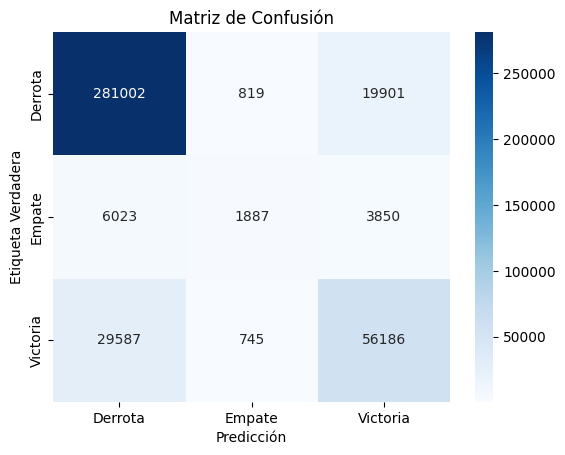

In [11]:
y_pred = model.predict(X_test).argmax(axis=1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Derrota', 'Empate', 'Victoria'], yticklabels=['Derrota', 'Empate', 'Victoria'])
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión')
plt.show()


### Informe de Clasificación

El **informe de clasificación** nos proporciona una visión detallada del rendimiento del modelo para cada clase y métricas globales. En este caso:

#### Métricas por clase:
- **Derrota**: 
  - **Precisión**: 0.89 - El modelo predice correctamente el 89% de las derrotas.
  - **Exhaustividad (Recall)**: 0.93 - Identifica el 93% de las derrotas reales.
  - **F1-Score**: 0.91 - Buena combinación de precisión y exhaustividad.
  - **Soporte**: 301,722 instancias.

- **Empate** (Margen de mejora): 
  - **Precisión**: 0.55 - Moderado rendimiento al predecir empates.
  - **Exhaustividad (Recall)**: 0.16 - Sólo identifica el 16% de los empates reales.
  - **F1-Score**: 0.25 - Bajo rendimiento en esta clase.
  - **Soporte**: 11,760 instancias.

- **Victoria**: 
  - **Precisión**: 0.70 - Buen desempeño en predecir victorias.
  - **Exhaustividad (Recall)**: 0.65 - Identifica el 65% de las victorias reales.
  - **F1-Score**: 0.68 - Balance razonable entre precisión y exhaustividad.
  - **Soporte**: 86,518 instancias.

#### Métricas globales:
- **Exactitud (Accuracy)**: 0.85 - El modelo clasifica correctamente el 85% de las instancias.
- **Promedio Macro (Macro Avg)**:
  - Promedio simple de las métricas entre clases: precisión 0.71, exhaustividad 0.58, F1 0.61.
  - Resalta que el rendimiento del modelo es inferior en clases minoritarias como "Empate".
- **Promedio Ponderado (Weighted Avg)**:
  - Promedio ponderado por el número de instancias en cada clase: precisión 0.84, exhaustividad 0.85, F1 0.84.
  - Refleja el impacto de las clases con mayor soporte, como "Derrota".

### Conclusión:
El modelo tiene un buen desempeño general (85% de exactitud), pero tiene algunos problemas en la predicción de empates por lo que hemos comentado anteriormente, posiblemente debido al bajo número de instancias de esta clase en el conjunto de datos.


In [12]:
print(classification_report(y_test, y_pred, target_names=['Derrota', 'Empate', 'Victoria']))

              precision    recall  f1-score   support

     Derrota       0.89      0.93      0.91    301722
      Empate       0.55      0.16      0.25     11760
    Victoria       0.70      0.65      0.68     86518

    accuracy                           0.85    400000
   macro avg       0.71      0.58      0.61    400000
weighted avg       0.84      0.85      0.84    400000



### Cargar el Modelo y el Escalador

Antes de realizar la predicción, verificamos si los archivos del modelo entrenado y el escalador ya existen. Si los archivos están disponibles, los cargamos para hacer la predicción sin necesidad de volver a entrenar el modelo. Si no existen, es necesario entrenar y guardar ambos.

- **Modelo**: Se carga el modelo previamente entrenado usando `load_model()`, lo que permite utilizarlo para hacer predicciones sin necesidad de reentrenar.
- **Escalador**: El escalador (`MinMaxScaler`) se carga con `joblib.load()`, para aplicar las transformaciones necesarias a los datos de entrada antes de realizar la predicción.

Si ambos archivos existen, se carga el modelo y el escalador; si no, se debe proceder con el entrenamiento y guardado.

In [21]:
if os.path.exists('models/poker_model.keras') and os.path.exists('models/scaler.pkl'):
    model = load_model('models/poker_model.keras')
    scaler = joblib.load('models/scaler.pkl')
    print("Modelo y escalador cargados correctamente.")
else:
    print("No se encontraron archivos guardados. Necesitas entrenar y guardar el modelo y el escalador. Ejecuta el notebook entero.")

Modelo y escalador cargados correctamente.


### Predicción de Probabilidades

In [13]:
y_prob = model.predict(X_test)

for i, prob in enumerate(y_prob[:10]):  # Muestra las primeras 10 filas
    print(f"Ejemplo {i+1}: Probabilidades -> Derrota: {prob[0]:.2f}, Empate: {prob[1]:.2f}, Victoria: {prob[2]:.2f}")


12500/12500 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step
Ejemplo 1: Probabilidades -> Derrota: 0.95, Empate: 0.02, Victoria: 0.03
Ejemplo 2: Probabilidades -> Derrota: 0.98, Empate: 0.00, Victoria: 0.02
Ejemplo 3: Probabilidades -> Derrota: 0.99, Empate: 0.00, Victoria: 0.00
Ejemplo 4: Probabilidades -> Derrota: 0.99, Empate: 0.00, Victoria: 0.00
Ejemplo 5: Probabilidades -> Derrota: 0.12, Empate: 0.00, Victoria: 0.88
Ejemplo 6: Probabilidades -> Derrota: 0.97, Empate: 0.00, Victoria: 0.03
Ejemplo 7: Probabilidades -> Derrota: 1.00, Empate: 0.00, Victoria: 0.00
Ejemplo 8: Probabilidades -> Derrota: 1.00, Empate: 0.00, Victoria: 0.00
Ejemplo 9: Probabilidades -> Derrota: 0.99, Empate: 0.00, Victoria: 0.00
Ejemplo 10: Probabilidades -> Derrota: 0.62, Empate: 0.10, Victoria: 0.27
